# Recopilar datos

In [1]:
import os
import tweepy
from tweepy import Stream
from stream_listener import FiniteStreamListener

### Cargar credenciales

In [2]:
CONSUMER_KEY = os.environ.get('TWITTER_CONSUMER_KEY')
CONSUMER_SECRET = os.environ.get('TWITTER_CONSUMER_SECRET')
ACCESS_TOKEN = os.environ.get('TWITTER_ACCES_TOKEN')
ACCESS_TOKEN_SECRET = os.environ.get('TWITTER_TOKEN_SECRET')

In [4]:
COLOMBIA_GEO_LOCATION_BOUNDING_BOX = [-78.31, 0.44, -70.71, 11.39]
NUMBER_OF_TWEETS = 100

In [5]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

### Establecer conexión al API de Twitter

In [6]:
finite_stream_listener = FiniteStreamListener(number_of_tweets = NUMBER_OF_TWEETS)
streaming_api = Stream(auth=auth, listener=finite_stream_listener)

### Extraer del firehouse

In [19]:
#streaming_api.filter(locations=COLOMBIA_GEO_LOCATION_BOUNDING_BOX)

# Limpiar datos

In [11]:
from unidecode import unidecode

### Definir funciones de limpieza

In [12]:
def make_lowercase(tweet):
    return tweet.lower()

def remove_diacritics(tweet):
    return unidecode(tweet)

def remove_non_alpha_characters(tweet):
    return ''.join(character for character in tweet if character.isalpha() or character == ' ')

### Aplicar funciones

In [13]:
cleaned_tweets = list(finite_stream_listener.tweets)

#It applies all the functions to all the tweets
for cleaning_function in [make_lowercase, remove_diacritics, remove_non_alpha_characters]:
    cleaned_tweets = [cleaning_function(tweet) for tweet in cleaned_tweets]

# Analizar datos

In [14]:
from pprint import pprint
import pandas as pd

In [15]:
KEYWORD = 'yo'

### Primeros 10 tweets

In [22]:
pprint(cleaned_tweets[:10])

['ese carlos antonio velez no me puede caer peor',
 'jaeduvelo jajaja jajajaja jajajaja httpstcofhifduey',
 'por favor no me manden nudes no pedidas si no se parecen a manuel '
 'josehttpstcomoisfnphvc',
 'cuando entenderan que son mas los inconformes y que eso es una '
 'estafalopagarasumadre httpstcobdzkvy',
 'los que yo doy los botan ',
 'amor lindo',
 'listos  httpstcoycibrvrp',
 'este gobierno uribestia esta empecinado en acabar con el medio ambiente '
 'colombiano paramo de santurban golfo de t httpstcomhhcsooay',
 'no les habia ensenado mi ascensor  httpstconbhrlg',
 ' httpstcoofwkvcgaw']


### ¿Cuántas veces aparece la palabra clave?

In [23]:
number_of_occurrences = sum(KEYWORD in tweet for tweet in cleaned_tweets)
print(f'La palabra clave aparece {number_of_occurrences} veces')

La palabra clave aparece 1 veces


### ¿Con qué frecuencia aparecio?

In [19]:
# Porcentaje
number_of_occurrences/len(cleaned_tweets)


0.05

### ¿Cómo son los tweets que tienen la palabra mencionada?

In [18]:
#Imprimir tweets que mencionan la palabra
pprint([ tweet for tweet in cleaned_tweets if KEYWORD in tweet])

['httpstcoxfpplbly alfredoramosm paolaholguin flondonohoyos pablojllovasco',
 'yosoyjuani ',
 'yo soy  mesinas lo que quiere decir que hasta mi nacimiento procastine por '
 'favor no me presionen',
 'yo pensaba que ak pesimo gobierno de samper iba a ser imposible que alguien '
 'lo igualara pero este porky lo esta su httpstcogkevvsdso',
 'youre weightless semierotic you need someone to take you there '
 'httpstcobkqcuq']


### ¿Cuál es la distancia promedio entre ocurrencias consecutivas?

In [20]:
# Obtener los indices que contienen la palabra
indices_of_tweets_containgin_keyword = [index for index, tweet in enumerate(cleaned_tweets) if KEYWORD in tweet]

In [21]:
distances_between_indices = [second_index - first_index for first_index, second_index in zip(
    indices_of_tweets_containgin_keyword[:-1], indices_of_tweets_containgin_keyword[1:]
)]

<AxesSubplot:>

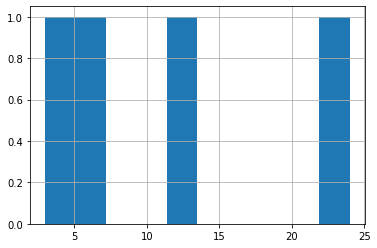

In [22]:
pd.Series(distances_between_indices).hist()

# Construir un modelo

In [23]:
 import matplotlib.pyplot as plt
 import numpy as np
 from scipy.stats import beta as beta_dist

### Definir los parametros de una Beta Distribution

In [24]:
alpha = 1 + number_of_occurrences
beta = 1 + (NUMBER_OF_TWEETS - number_of_occurrences)

x_values = np.linspace(0,1,1002)[1:-1]
pdf_y_values = beta_dist(alpha, beta).pdf(x_values)
cdf_y_values = np.cumsum(pdf_y_values) / np.sum(pdf_y_values)


### Visualizar

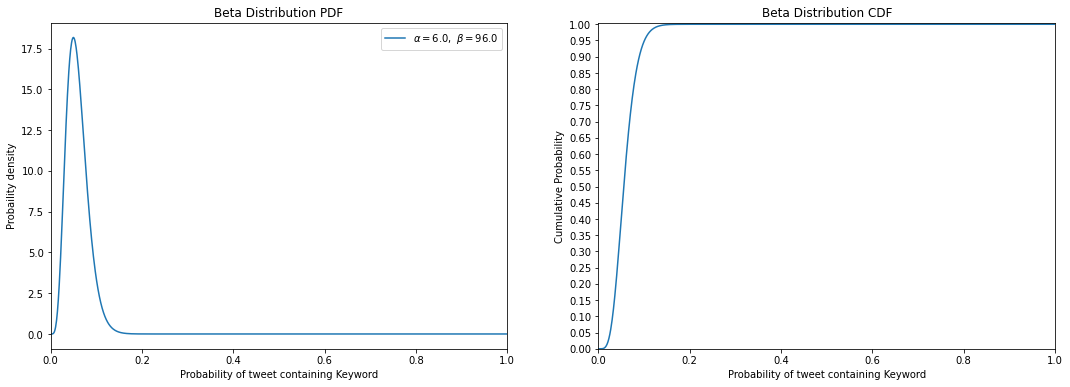

In [34]:
plt.figure(figsize=(18,6))

#PDF
plt.subplot(121)
plt.plot(x_values, pdf_y_values, label=(r'$\alpha=%.1f, \ \beta=%.1f$' % (alpha, beta)))
plt.xlim(0,1)
plt.xlabel('Probability of tweet containing Keyword')
plt.ylabel('Probaility density')
plt.title('Beta Distribution PDF')
plt.legend(loc=1)

#CFD
plt.subplot(122)
plt.plot(x_values, cdf_y_values)
plt.xlim(0,1)
plt.ylim(0,1.005)
plt.yticks(np.linspace(0,1,21)) #It add the separations in the y axis
plt.xlabel('Probability of tweet containing Keyword')
plt.ylabel('Cumulative Probability')
plt.title('Beta Distribution CDF')

plt.show()

# Comunicar resultados

Con 90% de certeza se puede decir la verdadera probabilidad:

In [35]:
fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values,cdf_y_values) if y_value <= 0.05])

ninety_fifth_percentile = max(
    [x_value for x_value, y_value in zip(x_values,cdf_y_values) if y_value <= 0.95])


In [36]:
print(f'Con 90% de certeza se puede decir que la verdadera probabilidad se encuentra entre {round(fifth_percentile, 4)} y {round(ninety_fifth_percentile, 4)}')

Con 90% de certeza se puede decir que la verdadera probabilidad se encuentra entre 0.025 y 0.0999


In [47]:
def compute_total_probability_less_p(p):
    #Compute the total probability that a probability is less than a value 'p'
    return max(cumulative_prob for cumulative_prob, x_value in zip(cdf_y_values, x_values) if x_value < p)

In [48]:
true_prob = 1 - compute_total_probability_less_p(.1)
print(f'La probabilidad de que la verdadera probabilidad sea > 0.1 es {true_prob}')

La probabilidad de que la verdadera probabilidad sea > 0.1 es 0.05283081449236837
